# 07. Model Training

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler, PowerTransformer,)
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

### Lendo o dataset tratado e visualizando o overview atual

In [3]:
df = pd.read_csv(consts.DATASET_LEAN) # Armazenando o dataset tratado em uma variável

In [4]:
df # Exbindo uma visão geral do dataset

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1,2,2,Real Bed,270.0,51.0,4,t,f,strict,2018,4
1,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1,1,2,Real Bed,161.0,45.0,4,f,f,strict,2018,4
2,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1,1,2,Real Bed,222.0,68.0,2,t,f,strict,2018,4
3,t,1.0,-22.988165,-43.193588,Apartment,Entire home/apt,3,1,1,2,Real Bed,308.0,86.0,2,f,f,strict,2018,4
4,t,1.0,-22.981269,-43.190457,Loft,Entire home/apt,2,1,1,2,Real Bed,219.0,80.0,3,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581978,f,1.0,-22.986030,-43.191660,Apartment,Entire home/apt,4,2,2,3,Real Bed,250.0,0.0,1,f,f,flexible,2019,9
581979,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1,0,2,Real Bed,121.0,50.0,1,f,f,flexible,2019,9
581980,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2,2,3,Real Bed,799.0,0.0,2,f,f,flexible,2019,9
581981,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1,1,1,Real Bed,250.0,0.0,1,f,f,strict_14_with_grace_period,2019,9


In [5]:
df.shape # Visualizando a quantidade de linhas e colunas do dataset

(581983, 19)

In [6]:
df.info() # Exibindo as informações das variáveis do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581983 entries, 0 to 581982
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         581983 non-null  object 
 1   host_listings_count       581983 non-null  float64
 2   latitude                  581983 non-null  float64
 3   longitude                 581983 non-null  float64
 4   property_type             581983 non-null  object 
 5   room_type                 581983 non-null  object 
 6   accommodates              581983 non-null  int64  
 7   bathrooms                 581983 non-null  int64  
 8   bedrooms                  581983 non-null  int64  
 9   beds                      581983 non-null  int64  
 10  bed_type                  581983 non-null  object 
 11  price                     581983 non-null  float64
 12  extra_people              581983 non-null  float64
 13  minimum_nights            581983 non-null  i

In [7]:
fn_stats.describe(df) # Usando a função que exibe as estatísticas das colunas numéricas

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,minimum_nights,ano,mes
count,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00
mean,1.71,-22.96,-43.25,3.47,1.36,1.36,2.10,319.63,22.38,2.55,2018.85,6.34
std,1.22,0.04,0.10,1.63,0.58,0.73,1.23,262.00,33.89,1.64,0.72,3.40
min,0.00,-23.07,-43.72,1.00,0.00,0.00,0.00,0.00,0.00,1.00,2018.00,1.00
25%,1.00,-22.98,-43.30,2.00,1.00,1.00,1.00,138.00,0.00,1.00,2018.00,4.00
50%,1.00,-22.97,-43.20,3.00,1.00,1.00,2.00,228.00,0.00,2.00,2019.00,6.00
75%,2.00,-22.94,-43.19,4.00,2.00,2.00,3.00,401.00,50.00,3.00,2019.00,9.00
max,6.00,-22.75,-43.10,9.00,3.00,3.00,6.00,1276.00,125.00,8.00,2020.00,12.00


In [8]:
df.describe(exclude='number') # Exibindo as estatísticas das colunas categóricas

,host_is_superhost,property_type,room_type,bed_type,instant_bookable,is_business_travel_ready,cancellation_policy
count,581983,581983,581983,581983,581983,581983,581983
unique,2,12,4,2,2,1,4
top,f,Apartment,Entire home/apt,Real Bed,f,f,flexible
freq,519412,458354,372443,570643,352395,581983,258096


In [9]:
df.isnull().sum() # Somando todos os valores nulos de cada coluna

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
price                       0
extra_people                0
minimum_nights              0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64

### Definindo os valores de x e y para o modelo de classificação definido

In [11]:
x = df.drop('price', axis=1) # Definindo os valores de x para o modelo, separando a variável target do dataset
y = df['price'] # Definindo os valores de y para o modelo, deixando o dataset somente com a variável target

In [12]:
x.head(3) # Visualizando os dados de x

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1,2,2,Real Bed,51.0,4,t,f,strict,2018,4
1,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1,1,2,Real Bed,45.0,4,f,f,strict,2018,4
2,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1,1,2,Real Bed,68.0,2,t,f,strict,2018,4


In [13]:
y.head(3) # Visualizando os dados de y

0    270.0
1    161.0
2    222.0
Name: price, dtype: float64

### Listando as variáveis numéricas e categóricas de x

In [14]:
numerical_features = x.select_dtypes(include='number').columns # Armazenando as features numéricas em uma variável
categorical_features = x.select_dtypes(exclude='number').columns # Armazenando as features categóricas em uma variável

print('- Numerical Features:') # Printando as variávei numéricas
for feature in numerical_features:
    print(feature)

print('\n- Categorical Features:') # Printando as variávei categóricas
for feature in categorical_features:
    print(feature)

- Numerical Features:
host_listings_count
latitude
longitude
accommodates
bathrooms
bedrooms
beds
extra_people
minimum_nights
ano
mes

- Categorical Features:
host_is_superhost
property_type
room_type
bed_type
instant_bookable
is_business_travel_ready
cancellation_policy


### Visualizando a distribuição das features de x em histogramas

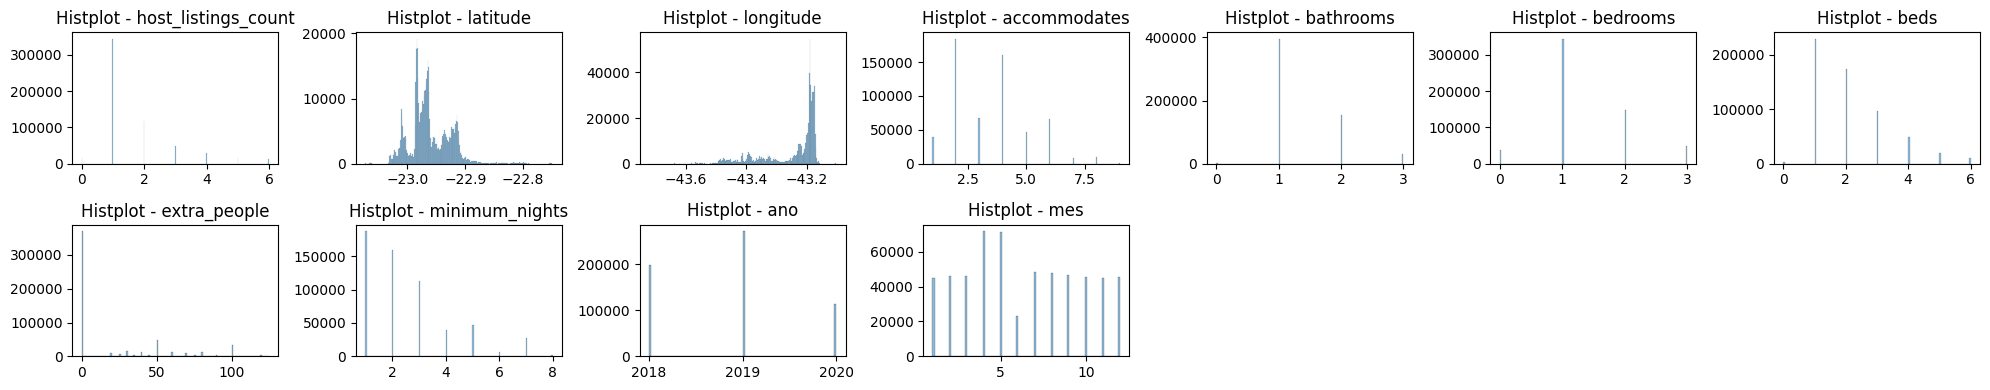

In [15]:
fn_charts.histplots(x, numerical_features, num_cols=7, height_figsize=2) # Criando os histplots para ver sua distribuição

### Definindo por qual procedimento cada feature de x vai passar

In [16]:
one_hot_cols = [ # Definindo as colunas que vão passar por One Hot Encoder
    'host_is_superhost', # Coluna categórica
    'property_type', # Coluna categórica
    'room_type', # Coluna categórica
    'bed_type', # Coluna categórica
    'instant_bookable', # Coluna categórica
    'is_business_travel_ready', # Coluna categórica
    'cancellation_policy', # Coluna categórica
    'host_listings_count', # Coluna com inteiros discretos
    'accommodates', # Coluna com inteiros discretos
    'bathrooms', # Coluna com inteiros discretos
    'bedrooms', # Coluna com inteiros discretos
    'beds', # Coluna com inteiros discretos
    'minimum_nights', # Coluna com inteiros discretos
]

power_cols = [ # Definindo as colunas que vão passar por Power Transformation
   'extra_people', # Coluna com assimetria dos dados
   'latitude', # Coluna com assimetria dos dados
   'longitude', # Coluna com assimetria dos dados
]

min_max_cols = [ # Definindo as colunas que vão passar por Min-Max Scaler
    'ano', # Coluna com distribuição uniforme dos dados
    'mes', # Coluna com distribuição uniforme dos dados
]

### Estabelecendo os pré processamentos que serão aplicados nas features antes da otimização de hiperparâmetros

In [17]:
preprocessing_initial = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
    [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
        ('one_hot', OneHotEncoder(), one_hot_cols),
        ('min_max', MinMaxScaler(), min_max_cols),
        ('power', PowerTransformer(), power_cols),
    ]
)

### Criando o pipeline para o modelo antes da otimização de hiperparâmetros

In [18]:
pipeline_initial = Pipeline( # Criando o pipeline para o modelo (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
    [ # Passando as etapas do pipeline
        ('pre_processing', preprocessing_initial), # Fazendo o pré processamento conforme as definições anteriores
        ('models', DecisionTreeRegressor(random_state=consts.RANDOM_STATE)), # Aplicando o modelo
    ]
)

### Treinando o modelo com os datasets x e y antes da otimização de hiperparâmetros

In [19]:
pipeline_initial.fit(x, y) # Fazendo o fit do pipeline com o x e o y

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['host_is_superhost',
                                                   'property_type', 'room_type',
                                                   'bed_type',
                                                   'instant_bookable',
                                                   'is_business_travel_ready',
                                                   'cancellation_policy',
                                                   'host_listings_count',
                                                   'accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'minimum_nights']),
                                                 ('min_max', MinMaxScaler(),
                                                  ['ano', 'mes']),
                                                 ('power', PowerTransformer(),
                                                  ['extra_people', 'latitude',
                                                   'longitude'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

### Fazendo o Cross Validate antes da otimização de hiperparâmetros

In [20]:
scores_initial = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
    pipeline_initial, # Passando o pipeline definido acima
    x, # Definindo o dataset x
    y, # Definindo o dataset y
    cv=KFold(n_splits=2, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset desbalanceado
    scoring=['r2', 'neg_root_mean_squared_error'], # Definindo as métricas de avaliação do modelo
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
)

### Criando um dataset com as métricas de avaliação do modelo antes da otimização de hiperparâmetros

In [34]:
scores_initial['time'] = scores_initial['fit_time'] + scores_initial['score_time'] # Criando a coluna de tempo somando fit_time e score_time
scores_initial['results'] = 'initial' # Criando uma coluna para separar os resultados iniciais e finais

df_results_initial = pd.DataFrame(scores_initial) # Criando um df transposto com os resultados dos modelos

df_results_initial['test_neg_root_mean_squared_error'] = df_results_initial['test_neg_root_mean_squared_error'] * -1 # Transformando em positivo

df_results_initial # Exibindo o dataset com os resultados iniciais

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,time,results
0,215.444200,1.217115,0.908390,79.366401,216.661315,initial
1,217.587439,1.138483,0.909981,78.541442,218.725921,initial


### Visualizando as métricas de avaliação do modelo antes da otimização de hiperparâmetros

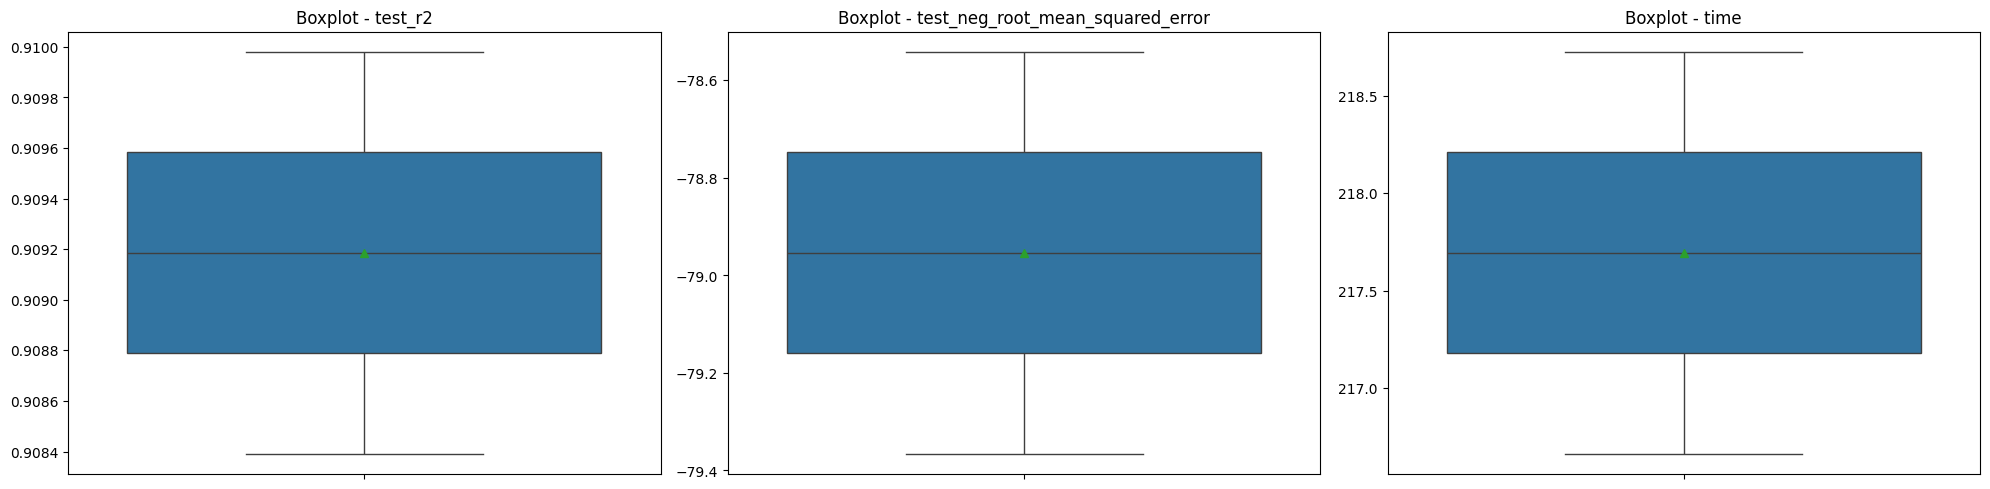

In [22]:
fn_charts.boxplots(df_results_initial, df_results_initial.columns[2:-1].to_list()) # Criando os boxplots para avaliação dos modelos

### Definindo as combinações de parâmetros que serão testados nas etapas do pipeline

In [26]:
params_grid_search = { # Definindo as combinações de parâmetros das etapas do pipeline serão testados (padrão: nome_etapa__parametro)
    # 'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'models__splitter': ['best', 'random'],
    # 'models__min_samples_split': [2, 3],
    'models__min_samples_leaf': [1, 2],
}

### Definindo os parâmetros do Grid Search

In [27]:
grid_search = GridSearchCV( # Aplicando o Grid Search
    pipeline_initial, # Definindo o pipeline
    params_grid_search, # Definindo as variações dos parâmetros que serão avaliados
    scoring=['r2', 'neg_root_mean_squared_error'], # Definindo as métricas que serão avaliadas
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
    refit='r2' # Definindo a métrica principal dentre as métricas avaliadas
)

### Treinando o modelo com a otimização de hiperparâmetros com o Grid Search

In [28]:
import warnings # Importando a biblioteca de warnings

warnings.filterwarnings('ignore') # Ignorando os avisos apenas pois há combinações de parâmetros que não podem ser feitas, retornando null

grid_search.fit(x, y) # Fazendo o fit do Grid Search com x e y

GridSearchCV(estimator=Pipeline(steps=[('pre_processing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['host_is_superhost',
                                                                          'property_type',
                                                                          'room_type',
                                                                          'bed_type',
                                                                          'instant_bookable',
                                                                          'is_business_travel_ready',
                                                                          'cancellation_policy',
                                                                          'host_listings_count',
                                                                          'accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'minimum_nights']),
                                                                        ('min_max',
                                                                         MinMaxScaler(),
                                                                         ['ano',
                                                                          'mes']),
                                                                        ('power',
                                                                         PowerTransformer(),
                                                                         ['extra_people',
                                                                          'latitude',
                                                                          'longitude'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-2,
             param_grid={'models__min_samples_leaf': [1, 2],
                         'models__splitter': ['best', 'random']},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

### Visualizando os melhores parâmetros encontrados pelo Grid Search

In [29]:
grid_search.best_params_ # Visualizando os melhores parâmetros encontrados pelo Grid Search

{'models__min_samples_leaf': 1, 'models__splitter': 'best'}

### Estabelecendo os pré processamentos que serão aplicados nas features com os melhores parâmetros encontrados pelo Grid Search

In [30]:
preprocessing_final = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
    [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
        ('one_hot', OneHotEncoder(), one_hot_cols),
        ('min_max', MinMaxScaler(), min_max_cols),
        ('power', PowerTransformer(), power_cols),
    ]
)

### Treinando o modelo com os melhores parâmetros encontrados pelo Grid Search

In [32]:
pipeline_final = Pipeline( # Criando o pipeline para o modelo (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
    [ # Passando as etapas do pipeline
        ('pre_processing', preprocessing_final), # Fazendo o pré processamento conforme as definições anteriores
        ('models', DecisionTreeRegressor(
            random_state=consts.RANDOM_STATE,
            # criterion=grid_search.best_params_['models__criterion'],
            splitter=grid_search.best_params_['models__splitter'],
            # min_samples_split=grid_search.best_params_['models__min_samples_split'],
            min_samples_leaf=grid_search.best_params_['models__min_samples_leaf'],
        )), # Aplicando o modelo
    ]
)

### Treinando o modelo com os datasets x e y após a otimização de hiperparâmetros

In [33]:
pipeline_final.fit(x, y) # Fazendo o fit do pipeline com o x e o y

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['host_is_superhost',
                                                   'property_type', 'room_type',
                                                   'bed_type',
                                                   'instant_bookable',
                                                   'is_business_travel_ready',
                                                   'cancellation_policy',
                                                   'host_listings_count',
                                                   'accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'minimum_nights']),
                                                 ('min_max', MinMaxScaler(),
                                                  ['ano', 'mes']),
                                                 ('power', PowerTransformer(),
                                                  ['extra_people', 'latitude',
                                                   'longitude'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

### Fazendo o Cross Validate com os melhores parâmetros encontrados pelo Grid Search

In [35]:
scores_final = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
    pipeline_final, # Passando o pipeline definido acima
    x, # Definindo o dataset x
    y, # Definindo o dataset y
    cv=KFold(n_splits=2, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset desbalanceado
    scoring=['r2', 'neg_root_mean_squared_error'], # Definindo as métricas de avaliação do modelo
    n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
)

### Criando um dataset com as métricas de avaliação do modelo com os melhores parâmetros encontrados pelo Grid Search

In [36]:
scores_final['time'] = scores_final['fit_time'] + scores_final['score_time'] # Criando a coluna de tempo somando fit_time e score_time
scores_final['results'] = 'final' # Criando uma coluna para separar os resultados iniciais e finais

df_results_final = pd.DataFrame(scores_final) # Criando um df transposto com os resultados dos modelos

df_results_final['test_neg_root_mean_squared_error'] = df_results_final['test_neg_root_mean_squared_error'] * -1 # Transformando em positivo

df_results_final # Exibindo o dataset com os resultados finais

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,time,results
0,283.514784,1.152128,0.908390,79.366401,284.666911,final
1,290.107474,1.088191,0.909981,78.541442,291.195664,final


### Visualizando as métricas de avaliação do modelo com os melhores parâmetros encontrados pelo Grid Search

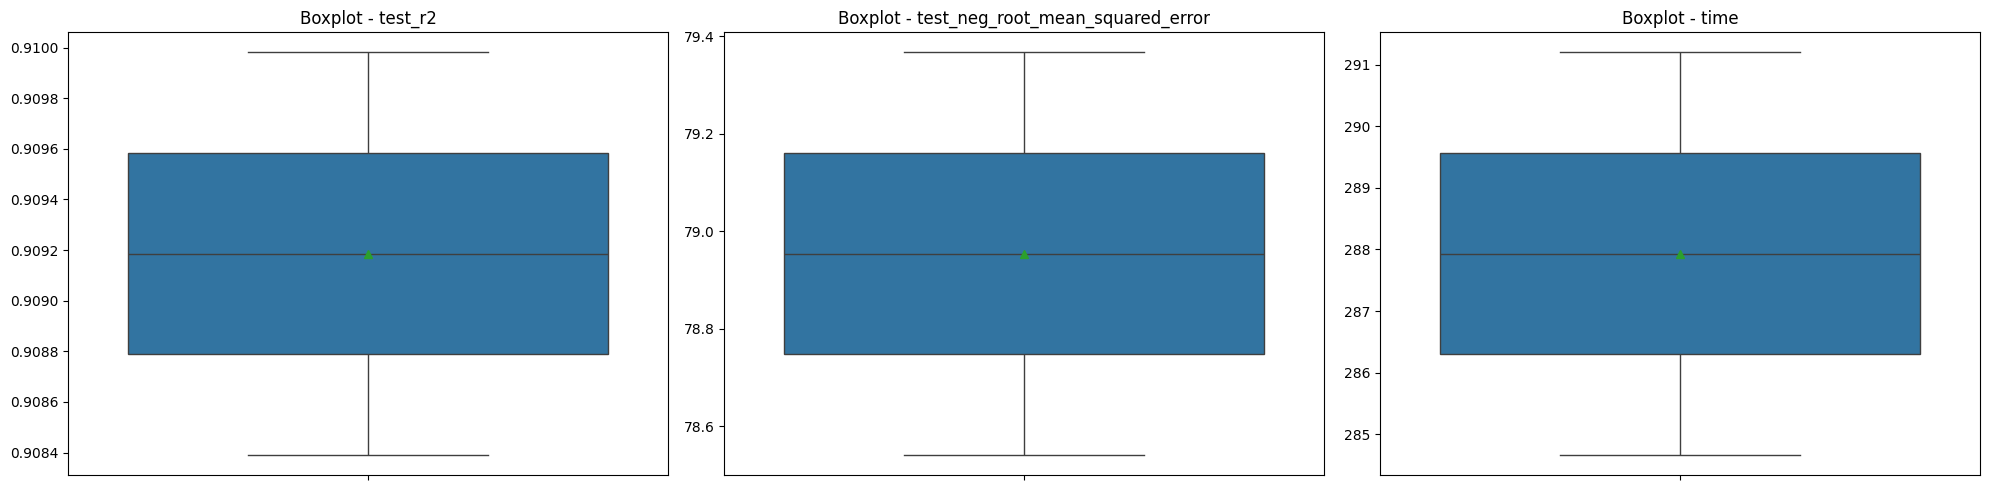

In [37]:
fn_charts.boxplots(df_results_final, df_results_final.columns[2:-1].to_list()) # Criando os boxplots para avaliação dos modelos

### Concatenando os dois datasets de resultados antes e depois para comparar as melhorias da otimização de hiperparâmetros

In [38]:
df_combined = pd.concat([df_results_final, df_results_initial], ignore_index=True) # Concatenando os dois datasets de antes e depois

df_combined # Exibindo o dataset concatenado

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,time,results
0,283.514784,1.152128,0.908390,79.366401,284.666911,final
1,290.107474,1.088191,0.909981,78.541442,291.195664,final
2,215.444200,1.217115,0.908390,79.366401,216.661315,initial
3,217.587439,1.138483,0.909981,78.541442,218.725921,initial


### Comparando os resultados de antes e depois da otimização de hiperparâmetros em boxplots

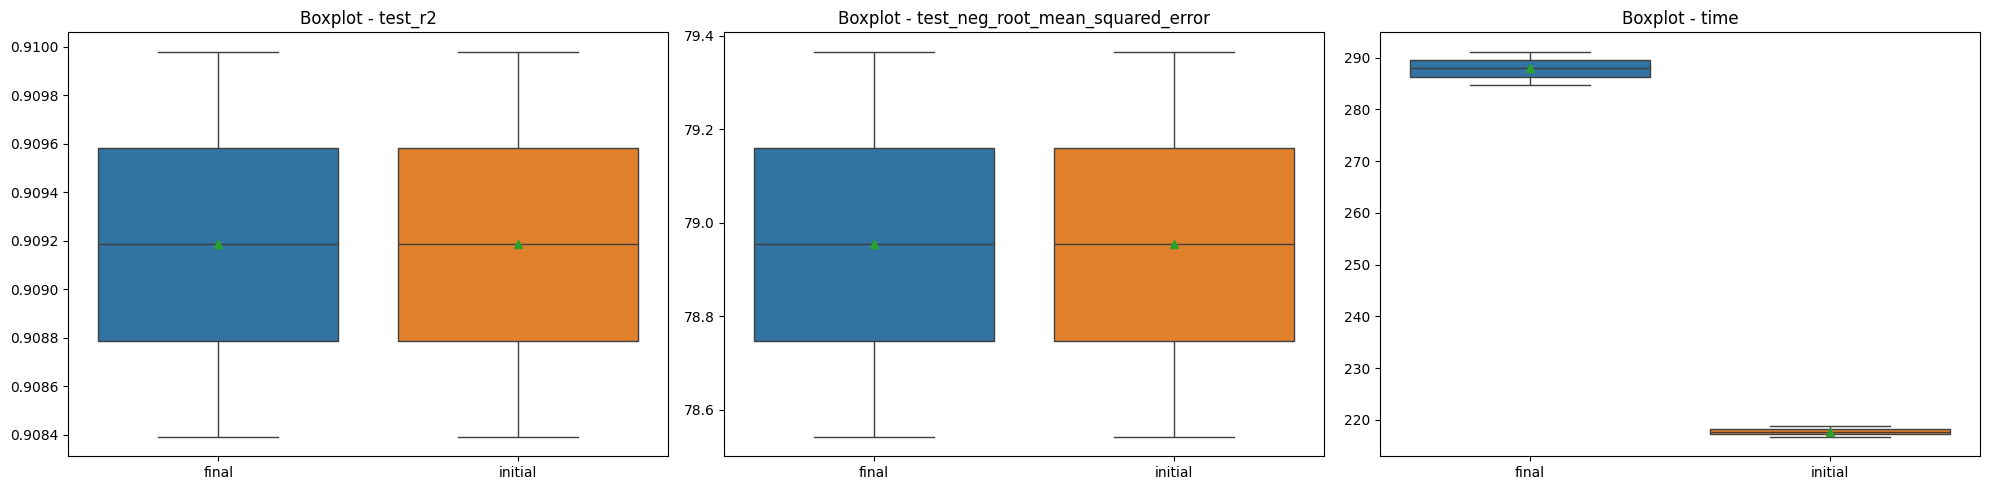

In [39]:
fn_charts.boxplots(df_combined, df_combined.columns[2:-1].to_list(), 'results') # Criando os boxplots para comparação dos modelos

### Comentando as técnicas usadas para evitar o overfitting do modelo

- **Validação Cruzada:** No aspecto de Validação Cruzada, foi aplicado o Stratified K-Fold, por ser um dataset desbalanceado, para dividir o conjunto de treinamento em várias partes (folds) e realizar o treinamento e validação do modelo em combinações diferentes desses folds, de modo que se obtém resultados mais confiáveis das métricas de avaliação do modelo e reduz o viés associado a uma única divisão do conjunto de treinamento
- **Otimização de Hiperparâmetros:** No aspecto de Otimização de Hiperparâmetros, foi aplicado o Grid Search para se combinar os melhores parâmetros das etapas do pipeline, de modo que se obtenha os melhores resultados nas métricas de avaliação para ter um modelo com boa performance e evitar o overfitting